# Лабораторная работа 3: Перенос знаний с использованием PyTorch

## Цели работы

Цель данной работы — изучить и реализовать метод переноса знаний (transfer learning) в глубоких нейронных сетях для решения задачи классификации отходов на основе набора данных [Garbage Classification]
(https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification). Предлагается применение метода переноса знаний к известным моделям глубокого обучения, обученных на наборе данных ImageNet.

## Перенос знаний

Перенос знаний — это метод, который позволяет улучшить сходимость модели на новых данных за счет лучшей начальной инициализации модели. В качестве начальной инициализации в таком случае выступают веса  полученной на исходном наборе данных. Этот подход часто применяется в задачах, где имеется мало данных, но есть смежный набор данных с обученной моделью.

Данный подход предполагает использование весов нейронной сети, обученной на одних данных, для начальной инициализации весов в другой, смежной задаче. В задачах классификации этот подход обычно предполагает изменение последнего слоя, поскольку количество нейронов в последнем слое определяется количеством классов в исходном наборе данных. Например, модель, обученная на ImageNet, будет иметь 1000 нейронов на последнем слое, а модель, обученная на MNIST, будет иметь 10 нейронов. Существуют различные подходы к переносу знаний:

- Обучение всех весов нейронной сети
- Обучение весов слоев, которые были добавлены или изменены
- Обучение нескольких последних слоев
- Обучение части слоев нейронной сети

Любая подобная конфигурация является допустимой и может помочь в решении задачи. Для определения наилучшей конфигурации необходимо провести эксперименты.

В задачах классификации последний слой обычно заменяют на один или несколько слоев. Количество нейронов в последнем слое при это должно быть равно количеству классов в новом наборе данных. Вместо последнего слоя также можно использовать классические модели машинного обучения, данный подход **нельзя** использовать в этой лабораторной работе!

##  Требования
1. Необходимо выполнить и отобразить в Jupyter следующие задачи:

    - Загрузить и проверить данные, включая демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей.
    - Загрузить 4 нейронные сети (можно использовать torchvision), обученные на наборе данных ImageNet. Требуется для каждой модели провести 2 эксперимента, используя разные конфигурация переноса знаний. Модифицировать последний слой и реализовать обучение на наборе данных Garbage Classification. Настроить гиперпараметры обучения.
    - Построить F1-score от количества эпох для всех моделей на валидационных данных. Построить сравнительную столбчатую диаграмму точностей: модель и тип эксперимента (с кратким указанием параметров) по горизонтали, F1 score на тестовых данных по вертикали.

2. Проверка корректности:

    - Разделите датасет на тренировочную, валидационную и тестовую выборки самостоятельно в соотношении 70/15/15.
    - Для оценки качества следует использовать Macro [F1-score](https://en.wikipedia.org/wiki/F-score), поскольку датасет не сбалансирован.

3. Архитектуры:

    - Можно использовать любые сверточные архитектуры или архитектуры на базе механизма внимания (transformer, ViT).
    - Хорошее понимание работы выбранных архитектур напрямую влияет на количество баллов за "знание". Будьте готовы кратко рассказать о примечательных особенностях выбранных или одной из выбранных архитектур при очной сдаче лабораторной работы. Не бойтесь выбирать сложные архитектуры - чем сложнее архитектура, тем больше шансов рассказать про нее что-то интересное и примечательное.
    

## Загрузка библиотек


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision import models
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Subset

### Гиперпараметры

In [4]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 64


## Загрузка набора данных

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification") + '\Garbage classification\Garbage classification'

print("Path to dataset files:", path)
print(type(path))

Path to dataset files: C:\Users\boris\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2\Garbage classification\Garbage classification
<class 'str'>


## Разделение датасета и проверка размерностей

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.484, 0.455, 0.406], std=[0.228, 0.223, 0.224])
])

dataset = datasets.ImageFolder(root=path, transform=transform)

classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f"Размер датасета: {len(dataset)}")
print(f"Размер тренировочной выборки: {len(train_data)}")
print(f"Размер валидационной выборки: {len(val_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Классы: {classes}")

Размер датасета: 2527
Размер тренировочной выборки: 1769
Размер валидационной выборки: 379
Размер тестовой выборки: 379
Классы: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Визуализация изображений с соответствующими метками

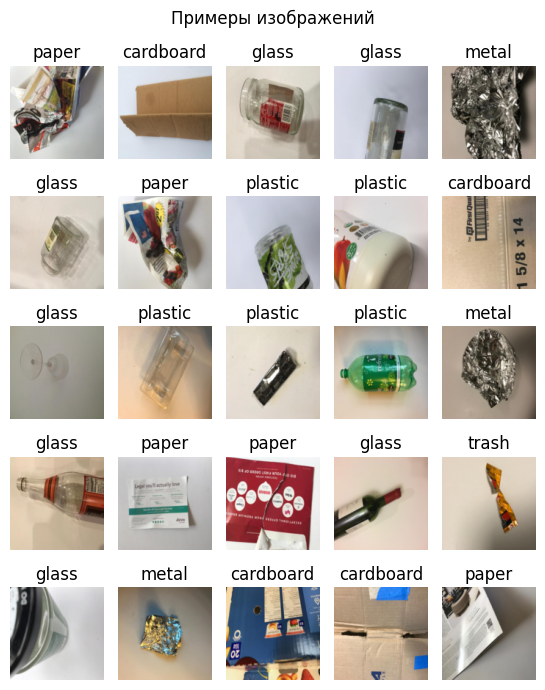

In [8]:
mean, std = [0.484, 0.455, 0.406], [0.228, 0.223, 0.224]
def show_images(dataset, num_images=15):
    fig, ax = plt.subplots(5, 5, figsize=(7,7))
    fig.suptitle("Примеры изображений")
    for images, labels in train_loader:
        for i in range(5):
            r = random.randint(1, len(dataset))
            for j in range(5):
                index = 5 * i + j
                image = images[index].permute(1, 2, 0).numpy()
                image = std * image + mean
                image = np.clip(image, 0, 1)
                ax[i, j].set_title(train_loader.dataset.dataset.classes[labels[index]])
                ax[i, j].imshow(image, cmap=plt.cm.binary)
                ax[i, j].axis('off')
        plt.tight_layout()
    plt.show()

show_images(dataset)

## Архитектуры

#### 1.VGG-16
#### 2.Shufflenet
#### 3.RESNET-50
#### 4.RESNET-101

In [9]:
f1 = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    print(param)
print("Stop")
for param in model.features[-6:].parameters():
    print(param)

Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149e-01,  9.8740

In [17]:
class VGG16:
    def classic(num_classes):
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.features[-6:].parameters():
            param.requires_grad = True

        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model

    def modified(num_classes):
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.features[24:].parameters():
            param.requires_grad = True

        model.avgpool = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        model.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
        return model

In [18]:
class ResNet50:
    def classic(num_classes):
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
        for params in model.parameters():
            params.requires_grad = False
        last_layer = model.fc.in_features
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
        return model

    def modificate(num_classes):
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
        for params in model.parameters():
            params.requires_grad = False
        last_layer = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(model.fc.in_features, model.fc.in_features//2).to(device),
                                nn.ReLU().to(device),
                                nn.Linear(model.fc.in_features//2, num_classes)).to(device)
        return model

class ResNet101:
    def classic(num_classes):
        model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2).to(device)
        for params in model.parameters():
            params.requires_grad = False
        last_layer = model.fc.in_features
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
        return model

    def modificate(num_classes):
        model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2).to(device)
        for params in model.parameters():
            params.requires_grad = False
        last_layer = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(model.fc.in_features, model.fc.in_features//2).to(device),
                                nn.ReLU().to(device),
                                nn.Linear(model.fc.in_features//2, num_classes)).to(device)
        return model


#### Shufflenet

In [19]:
class Shufflenet:
    def classic(num_classes):
        model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model

    def modified(num_classes):
        model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False

        model.fc = nn.Sequential(
            nn.BatchNorm1d(model.fc.in_features),
            nn.Dropout(0.4),
            nn.Linear(model.fc.in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )
        return model

In [20]:
classes = dataset.classes

## Обучение моделей

In [ ]:
@torch.no_grad()
def accuracy(model, dataloader: DataLoader):
    device = next(model.parameters()).device
    correct = 0
    total = 0
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += 
        
        
        total += labels.size(0)
    return correct / total

@torch.no_grad()
def f1_calculate(model, dataloader: DataLoader):
    device = next(model.parameters()).device
    f1_all = []
    model.eval()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_all.append(f1)
    return sum(f1_all) / len(f1_all)

def train_model(model, name, train_loader, val_loader, num_epochs, learning_rate):
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0
    val_f1_stat = []

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        total_train_correct = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total_train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = total_train_correct / total_train
        train_time = time.time() - start_time

        start_time = time.time()
        val_f1 = f1_calculate(model, val_loader)
        val_accuracy = accuracy(model, val_loader)
        val_time = time.time() - start_time

        if val_f1 > best_f1:
            torch.save(model.state_dict(), f"best_{name}.pth")
            best_f1 = val_f1

        val_f1_stat.append(val_f1)

        print(f'Эпоха [{epoch + 1}/{num_epochs}]')
        print(f'Время обучения = {train_time:.4f} секунд, Точность тренировки = {train_accuracy:.4f}')
        print(f"Время валидации = {val_time:.4f} секунд, F1 валидации = {val_f1:.4f}, Точность валидации = {val_accuracy:.4f}")
        print()

    test_accuracy = accuracy(model, test_loader)
    print(f'Тестовая точность = {test_accuracy:.4f}')

    return val_f1_stat

def run(model_factory, name):
    global f1
    model = model_factory(len(classes)).to(device)
    name = name
    val_f1_stat = train_model(model, name, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
    model.load_state_dict(torch.load(f'best_{name}.pth', weights_only=True))
    test_f1 = f1_calculate(model, test_loader)
    print(f'Test F1 = {test_f1:.4f}')
    plt.plot(range(NUM_EPOCHS), val_f1_stat, marker='o', color='red')
    plt.title(f'{name} validation')
    plt.xlabel('epochs')
    plt.xticks([i for i in range(NUM_EPOCHS)])
    plt.ylabel('F1 score')
    plt.grid()
    plt.show()
    f1[name] = test_f1


## Эксперименты

#### VGG-16

Эпоха [1/20]
Время обучения = 52.8776 секунд, Точность тренировки = 0.4941
Время валидации = 30.4719 секунд, F1 валидации = 0.4796, Точность валидации = 0.5620

Эпоха [2/20]
Время обучения = 167.4055 секунд, Точность тренировки = 0.6546
Время валидации = 55.2211 секунд, F1 валидации = 0.5342, Точность валидации = 0.6412

Эпоха [3/20]
Время обучения = 224.0115 секунд, Точность тренировки = 0.7699
Время валидации = 55.3372 секунд, F1 валидации = 0.7190, Точность валидации = 0.7757

Эпоха [4/20]
Время обучения = 229.8371 секунд, Точность тренировки = 0.7925
Время валидации = 55.3283 секунд, F1 валидации = 0.7375, Точность валидации = 0.8074

Эпоха [5/20]
Время обучения = 103.8939 секунд, Точность тренировки = 0.8762
Время валидации = 15.0948 секунд, F1 валидации = 0.6956, Точность валидации = 0.7757

Эпоха [6/20]
Время обучения = 52.5906 секунд, Точность тренировки = 0.8705
Время валидации = 15.2366 секунд, F1 валидации = 0.7239, Точность валидации = 0.7652

Эпоха [7/20]
Время обучения = 

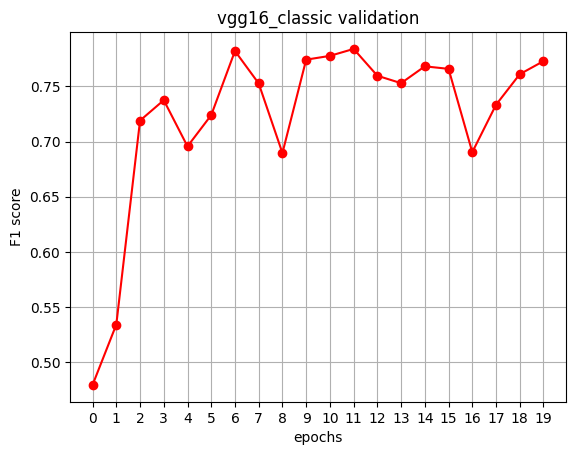

In [22]:
run(VGG16.classic, 'vgg16_classic')

Эпоха [1/20]
Время обучения = 38.7199 секунд, Точность тренировки = 0.6897
Время валидации = 14.3866 секунд, F1 валидации = 0.7115, Точность валидации = 0.7995

Эпоха [2/20]
Время обучения = 38.7345 секунд, Точность тренировки = 0.8615
Время валидации = 14.4011 секунд, F1 валидации = 0.7255, Точность валидации = 0.7784

Эпоха [3/20]
Время обучения = 38.5187 секунд, Точность тренировки = 0.9237
Время валидации = 14.4684 секунд, F1 валидации = 0.7539, Точность валидации = 0.8100

Эпоха [4/20]
Время обучения = 38.6108 секунд, Точность тренировки = 0.9712
Время валидации = 14.4565 секунд, F1 валидации = 0.7740, Точность валидации = 0.8127

Эпоха [5/20]
Время обучения = 38.5204 секунд, Точность тренировки = 0.9796
Время валидации = 14.3430 секунд, F1 валидации = 0.7371, Точность валидации = 0.8470

Эпоха [6/20]
Время обучения = 38.6560 секунд, Точность тренировки = 0.9768
Время валидации = 14.3436 секунд, F1 валидации = 0.7048, Точность валидации = 0.7573

Эпоха [7/20]
Время обучения = 38.8

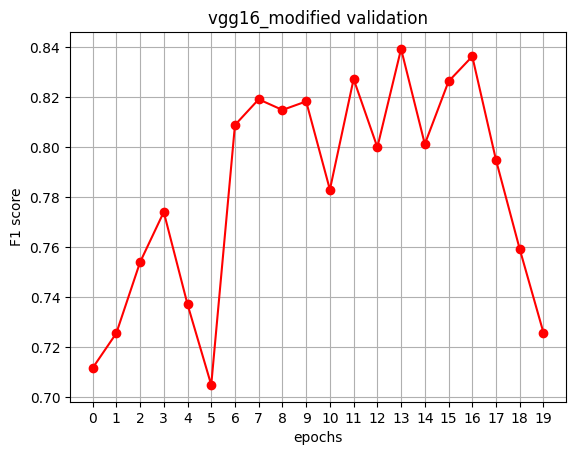

In [23]:
run(VGG16.modified, 'vgg16_modified')

#### Resnet

Эпоха [1/20]
Время обучения = 19.9393 секунд, Точность тренировки = 0.5444
Время валидации = 7.9650 секунд, F1 валидации = 0.6259, Точность валидации = 0.7414

Эпоха [2/20]
Время обучения = 20.0195 секунд, Точность тренировки = 0.7852
Время валидации = 7.9165 секунд, F1 валидации = 0.7120, Точность валидации = 0.7968

Эпоха [3/20]
Время обучения = 20.3329 секунд, Точность тренировки = 0.8282
Время валидации = 7.9041 секунд, F1 валидации = 0.7279, Точность валидации = 0.8127

Эпоха [4/20]
Время обучения = 20.0091 секунд, Точность тренировки = 0.8677
Время валидации = 14.1258 секунд, F1 валидации = 0.7399, Точность валидации = 0.8232

Эпоха [5/20]
Время обучения = 39.6415 секунд, Точность тренировки = 0.8807
Время валидации = 7.9646 секунд, F1 валидации = 0.7568, Точность валидации = 0.8311

Эпоха [6/20]
Время обучения = 36.5710 секунд, Точность тренировки = 0.9096
Время валидации = 18.1916 секунд, F1 валидации = 0.7341, Точность валидации = 0.8232

Эпоха [7/20]
Время обучения = 20.4970 

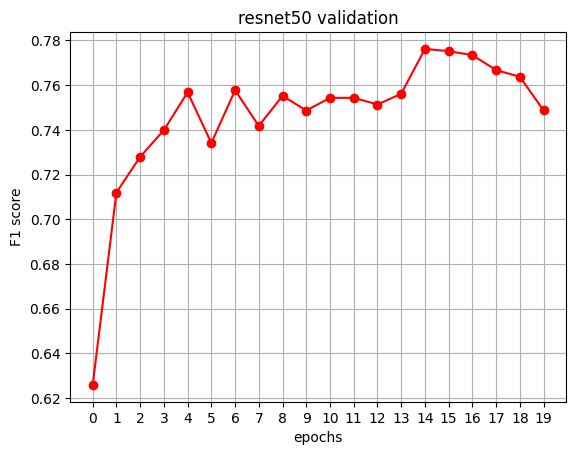

In [24]:
run(ResNet50.classic, 'resnet50')

Эпоха [1/20]
Время обучения = 47.1534 секунд, Точность тренировки = 0.6196
Время валидации = 20.6414 секунд, F1 валидации = 0.6808, Точность валидации = 0.7652

Эпоха [2/20]
Время обучения = 52.8429 секунд, Точность тренировки = 0.8123
Время валидации = 20.6001 секунд, F1 валидации = 0.7193, Точность валидации = 0.7863

Эпоха [3/20]
Время обучения = 52.8674 секунд, Точность тренировки = 0.8513
Время валидации = 20.6440 секунд, F1 валидации = 0.7490, Точность валидации = 0.8153

Эпоха [4/20]
Время обучения = 52.9670 секунд, Точность тренировки = 0.8790
Время валидации = 20.6478 секунд, F1 валидации = 0.7874, Точность валидации = 0.8338

Эпоха [5/20]
Время обучения = 28.4086 секунд, Точность тренировки = 0.8960
Время валидации = 8.0665 секунд, F1 валидации = 0.7421, Точность валидации = 0.8153

Эпоха [6/20]
Время обучения = 20.4261 секунд, Точность тренировки = 0.9112
Время валидации = 8.0131 секунд, F1 валидации = 0.7640, Точность валидации = 0.8364

Эпоха [7/20]
Время обучения = 20.316

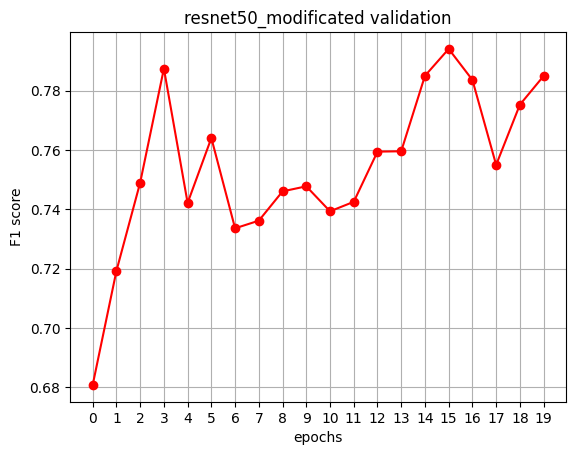

In [25]:
run(ResNet50.modificate, 'resnet50_modificated')

Эпоха [1/20]
Время обучения = 29.1837 секунд, Точность тренировки = 0.5664
Время валидации = 11.4368 секунд, F1 валидации = 0.6452, Точность валидации = 0.7546

Эпоха [2/20]
Время обучения = 29.0572 секунд, Точность тренировки = 0.7954
Время валидации = 11.4428 секунд, F1 валидации = 0.6707, Точность валидации = 0.7652

Эпоха [3/20]
Время обучения = 29.0492 секунд, Точность тренировки = 0.8440
Время валидации = 11.4449 секунд, F1 валидации = 0.7150, Точность валидации = 0.7863

Эпоха [4/20]
Время обучения = 29.0023 секунд, Точность тренировки = 0.8779
Время валидации = 11.4460 секунд, F1 валидации = 0.7101, Точность валидации = 0.7889

Эпоха [5/20]
Время обучения = 28.9826 секунд, Точность тренировки = 0.9039
Время валидации = 11.4260 секунд, F1 валидации = 0.7336, Точность валидации = 0.7968

Эпоха [6/20]
Время обучения = 28.9666 секунд, Точность тренировки = 0.9152
Время валидации = 11.5034 секунд, F1 валидации = 0.7135, Точность валидации = 0.7942

Эпоха [7/20]
Время обучения = 28.9

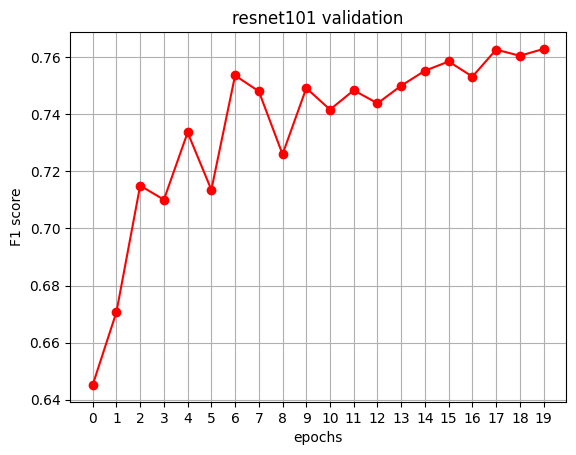

In [26]:
run(ResNet101.classic, 'resnet101')

Эпоха [1/20]
Время обучения = 29.2055 секунд, Точность тренировки = 0.6433
Время валидации = 11.4110 секунд, F1 валидации = 0.7043, Точность валидации = 0.7889

Эпоха [2/20]
Время обучения = 29.2153 секунд, Точность тренировки = 0.8016
Время валидации = 11.4483 секунд, F1 валидации = 0.7518, Точность валидации = 0.7889

Эпоха [3/20]
Время обучения = 29.2621 секунд, Точность тренировки = 0.8626
Время валидации = 11.4392 секунд, F1 валидации = 0.7546, Точность валидации = 0.7968

Эпоха [4/20]
Время обучения = 29.2061 секунд, Точность тренировки = 0.8683
Время валидации = 11.4909 секунд, F1 валидации = 0.7534, Точность валидации = 0.7942

Эпоха [5/20]
Время обучения = 29.1653 секунд, Точность тренировки = 0.8785
Время валидации = 11.4532 секунд, F1 валидации = 0.7535, Точность валидации = 0.7968

Эпоха [6/20]
Время обучения = 29.1505 секунд, Точность тренировки = 0.8932
Время валидации = 11.4907 секунд, F1 валидации = 0.7737, Точность валидации = 0.8100

Эпоха [7/20]
Время обучения = 29.1

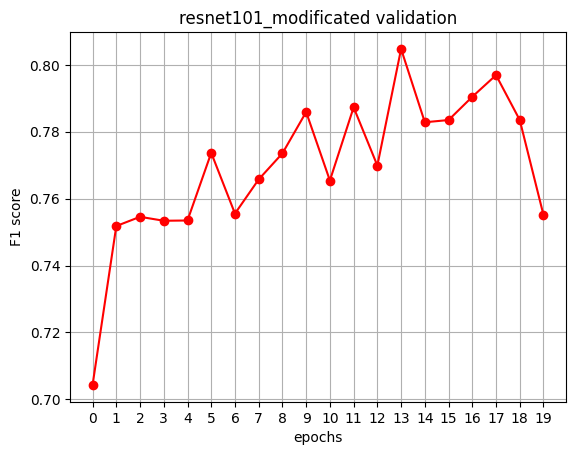

In [27]:
run(ResNet101.modificate, 'resnet101_modificated')

#### Shufflenet

Эпоха [1/20]
Время обучения = 8.3762 секунд, Точность тренировки = 0.6162
Время валидации = 1.7615 секунд, F1 валидации = 0.6691, Точность валидации = 0.7942

Эпоха [2/20]
Время обучения = 8.2262 секунд, Точность тренировки = 0.8282
Время валидации = 1.7594 секунд, F1 валидации = 0.7031, Точность валидации = 0.8391

Эпоха [3/20]
Время обучения = 8.2671 секунд, Точность тренировки = 0.8864
Время валидации = 1.7452 секунд, F1 валидации = 0.7291, Точность валидации = 0.8549

Эпоха [4/20]
Время обучения = 8.2046 секунд, Точность тренировки = 0.9265
Время валидации = 1.7940 секунд, F1 валидации = 0.7960, Точность валидации = 0.8760

Эпоха [5/20]
Время обучения = 8.5030 секунд, Точность тренировки = 0.9683
Время валидации = 1.7740 секунд, F1 валидации = 0.8452, Точность валидации = 0.8813

Эпоха [6/20]
Время обучения = 7.9676 секунд, Точность тренировки = 0.9813
Время валидации = 1.6603 секунд, F1 валидации = 0.8077, Точность валидации = 0.8734

Эпоха [7/20]
Время обучения = 8.2105 секунд, Т

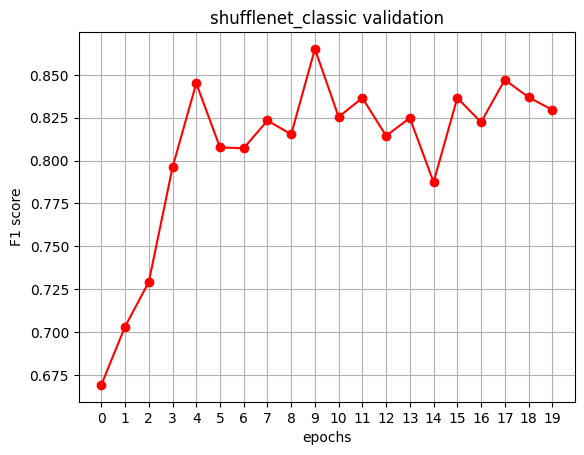

In [28]:
run(Shufflenet.classic, 'shufflenet_classic')

Эпоха [1/20]
Время обучения = 4.4759 секунд, Точность тренировки = 0.6540
Время валидации = 1.7890 секунд, F1 валидации = 0.4706, Точность валидации = 0.5172

Эпоха [2/20]
Время обучения = 4.4756 секунд, Точность тренировки = 0.8400
Время валидации = 1.7829 секунд, F1 валидации = 0.8127, Точность валидации = 0.8443

Эпоха [3/20]
Время обучения = 4.5051 секунд, Точность тренировки = 0.8751
Время валидации = 1.7747 секунд, F1 валидации = 0.8212, Точность валидации = 0.8602

Эпоха [4/20]
Время обучения = 4.5081 секунд, Точность тренировки = 0.8915
Время валидации = 1.7630 секунд, F1 валидации = 0.7962, Точность валидации = 0.8628

Эпоха [5/20]
Время обучения = 4.4439 секунд, Точность тренировки = 0.9192
Время валидации = 1.7730 секунд, F1 валидации = 0.7984, Точность валидации = 0.8681

Эпоха [6/20]
Время обучения = 4.4669 секунд, Точность тренировки = 0.9322
Время валидации = 1.7882 секунд, F1 валидации = 0.8026, Точность валидации = 0.8707

Эпоха [7/20]
Время обучения = 4.4169 секунд, Т

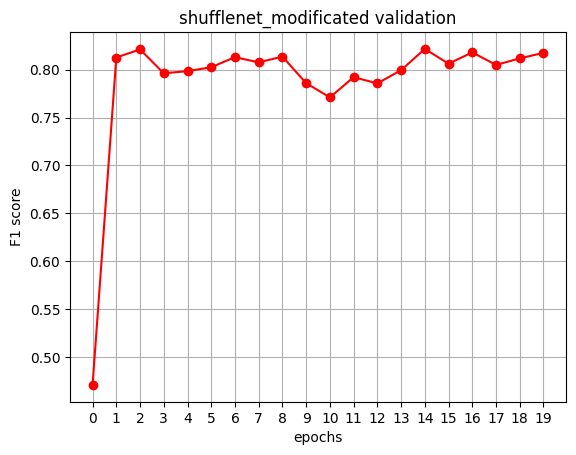

In [29]:
run(Shufflenet.modified, 'shufflenet_modificated')

## Диаграмма точностей

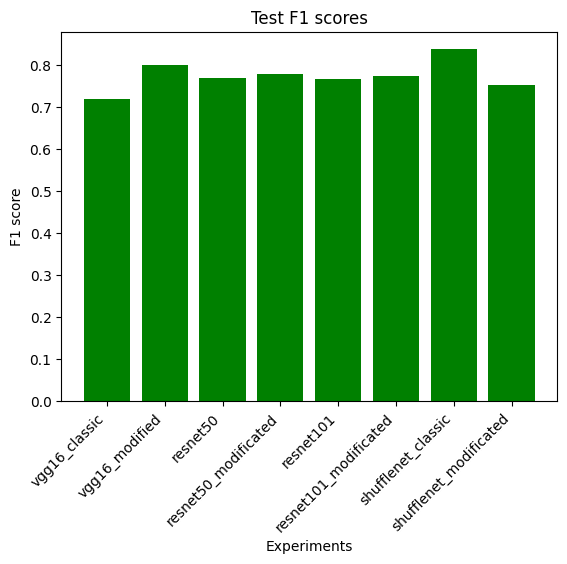

In [30]:


model_names = [*f1.keys()]
f1_scores = [*f1.values()]
plt.bar(model_names, f1_scores, color = "green")
plt.xlabel("Experiments")
plt.ylabel("F1 score")
plt.title("Test F1 scores")
plt.xticks(rotation = 45, ha = "right")
plt.show()